In [1]:
%load_ext autotime

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from keras.applications.densenet import DenseNet169
from keras.utils import np_utils
from keras.utils import to_categorical
from keras.models import load_model
from keras.preprocessing.image import ImageDataGenerator
from keras import layers
from keras import optimizers
from keras import metrics
from keras import models
from keras.utils import plot_model, multi_gpu_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras_applications.densenet import *

from keras_tqdm import TQDMNotebookCallback
from ipywidgets import IntProgress, HTML, HBox


from pathlib import Path
import pickle

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


time: 3.47 s


In [3]:
import logging

log = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO)

time: 2.34 ms


In [4]:
import tensorflow as tf
from keras import backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
K.set_session(sess)

time: 2.87 s


In [5]:
import utils # importing from our utils functions

time: 4.95 s


In [6]:
x_train, y_train, x_test, y_test = utils.read_mura_pickle()
x_train = utils.normalize_pixels(x_train)
x_test = utils.normalize_pixels(x_test)

INFO:utils.utils:loading data/MURA-v1.1/x_train.pkl
INFO:utils.utils:loading data/MURA-v1.1/y_train.pkl
INFO:utils.utils:loading data/MURA-v1.1/x_valid.pkl
INFO:utils.utils:loading data/MURA-v1.1/y_valid.pkl


time: 16 s


In [7]:
x_train.shape

(36808, 256, 256)

time: 6.08 ms


In [8]:
size = x_train.shape[1]
x_train = x_train.reshape(x_train.shape[0], size, size, 1)
x_test = x_test.reshape(x_test.shape[0], size, size, 1)

time: 2.33 ms


In [9]:
datagen = ImageDataGenerator(
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=[0.8, 1.2],
    fill_mode = 'constant',
    cval=0,
    horizontal_flip=True,
    vertical_flip=True)

time: 3.38 ms


In [ ]:
datagen.fit(x_train)

# Set up model

In [ ]:
base_weights = '5_0_base_layers_30_single_gpu_weights'
classifier_model = '3_1_body_part_classifier_dense169_151'

In [ ]:
bodyparts = ['shoulder', 'humerus', 'finger', 'elbow', 'wrist', 'forearm', 'hand']

In [13]:
with tf.device('/CPU:0'):
    
    log.info(f'loading classifier {classifier_model}...')
    classifier = models.load_model(f'trained_models/{classifier_model}.h5')
    log.info('locking classifier layers...')
    for mid_layer in classifier.layers:
        mid_layer.trainable = False
        mid_layer.name = 'c_' + mid_layer.name
    
    log.info('making base model ...')
    
    blocks=[6, 12, 32, 32]
    bn_axis = 3
    x = layers.ZeroPadding2D(padding=((3, 3), (3, 3)))(classifier.input)
    x = layers.Conv2D(64, 7, strides=2, use_bias=False, name='conv1/conv')(x)
    x = layers.BatchNormalization(
        axis=bn_axis, epsilon=1.001e-5, name='conv1/bn')(x)
    x = layers.Activation('relu', name='conv1/relu')(x)
    x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)))(x)
    x = layers.MaxPooling2D(3, strides=2, name='pool1')(x)

    x = dense_block(x, blocks[0], name='conv2')
    x = transition_block(x, 0.5, name='pool2')
    x = dense_block(x, blocks[1], name='conv3')
    x = transition_block(x, 0.5, name='pool3')
    x = dense_block(x, blocks[2], name='conv4')
    x = transition_block(x, 0.5, name='pool4')
    x = dense_block(x, blocks[3], name='conv5')
    x = layers.BatchNormalization(
        axis=bn_axis, epsilon=1.001e-5, name='bn')(x)
    x = layers.Flatten()(x)
    x = layers.Dense(1, activation='sigmoid')(x)
    base_dense = models.Model(input=classifier.input, output=x, name='base_dense')
    
    log.info(f'loading weights {base_weights}...')
    base_dense.load_weights(f'trained_models/{base_weights}.h5')
    
    base_block4_out = base_dense.get_layer('pool4_pool')
    
    log.info('linking new top layers...')
    last_out = []
    for i in range(7):
        x = dense_block(base_block4_out.output, 32, f'conv5_{bodyparts[i]}')
        x = layers.BatchNormalization(axis=3, epsilon=1.001e-5, name=f'bn_{bodyparts[i]}')(x)
        x = layers.GlobalAveragePooling2D(name=f'avg_pool_{bodyparts[i]}')(x)
        x = layers.Dense(1, activation='sigmoid', name=f'fc_{bodyparts[i]}')(x)
        last_out.append(x)
    
    concat = layers.Concatenate(1)(last_out)
    dot = layers.Dot(axes=1)([concat, classifier.output])
    
    log.info('linking classifier with new top layers...')
    ensemble = models.Model(input=classifier.input, output=dot)

INFO:__main__:loading classifier 3_1_body_part_classifier_dense169_151...
INFO:__main__:locking classifier layers...
INFO:__main__:making base model ...
INFO:__main__:loading weights 5_0_base_layers_30_single_gpu_weights...
INFO:__main__:linking new top layers...
INFO:__main__:linking classifier with new top layers...


time: 2min 16s


In [14]:
plot_model(ensemble, '5_1_ensemble.png')

time: 7.81 s


In [15]:
# Lock shared layers
for mid_layer in ensemble.layers:
    mid_layer.trainable = False
    if 'pool4_pool' in mid_layer.name:
        break

time: 1.97 ms


In [16]:
model = multi_gpu_model(ensemble, gpus=4)

time: 14min 45s


In [17]:
clr_history = {'lr': [], 'loss': [], 'binary_accuracy': []}
train_history = {'loss': [], 'binary_accuracy': []}
val_per_image_history = {'accuracy': [], 'kappa': [], 'precision': [], 'recall': []}
val_per_study_history = {'accuracy': [], 'kappa': [], 'precision': [], 'recall': []}

time: 1 ms


In [7]:
starting_epoch = 0
train_round = 0
batch_size = 16
epochs_per_eval = 10
epochs_per_save = 10
total_epochs = 500
optimizer = 'adam'
base_lr = 1e-5
max_lr = 1e-4
model_name='5_1_shared_net'

time: 2.39 ms


In [19]:
def weighted_binary_crossentropy(p1):
    '''
    p1 is the proportion of ones in population
    '''
    w0 = K.variable(p1)
        
    def loss(y_true, y_pred):
        # clip to prevent NaN's and Inf's
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = -(1 - w0) * y_true * K.log(y_pred) - w0 * (1 - y_true) * K.log(1 - y_pred)
        loss = K.sum(loss, -1)
        return loss
    
    return loss

time: 1.7 ms


In [20]:
clr = utils.clr.CyclicLR(mode='triangular2', base_lr=base_lr, max_lr=max_lr)

time: 1.94 ms


In [21]:
opt = optimizers.Adam(lr=base_lr, amsgrad=True)

time: 13.2 ms


In [22]:
p1 = y_train.mean()

time: 1.02 ms


In [23]:
progress = TQDMNotebookCallback(leave_inner=True, leave_outer=True) 

time: 1.09 ms


In [8]:
with open(f'./trained_models/{model_name}_clr_history.pkl', 'rb') as pkl_file:
    clr_history = pickle.load(pkl_file)
with open(f'./trained_models/{model_name}_train_history.pkl', 'rb') as pkl_file:
    train_history = pickle.load(pkl_file)
with open(f'./trained_models/{model_name}_val_per_image_history.pkl', 'rb') as pkl_file:
    val_per_image_history = pickle.load(pkl_file)
with open(f'./trained_models/{model_name}_val_per_study_history.pkl', 'rb') as pkl_file:
    val_per_study_history = pickle.load(pkl_file)

time: 50.7 ms


INFO:__main__:executing epochs 1-10


INFO:utils.mura_metrics:Accuracy: 0.8167031592117611
INFO:utils.mura_metrics:Kappa: 0.6314252235322263
INFO:utils.mura_metrics:Precision: 0.8376251788268956
INFO:utils.mura_metrics:Recall: 0.765359477124183


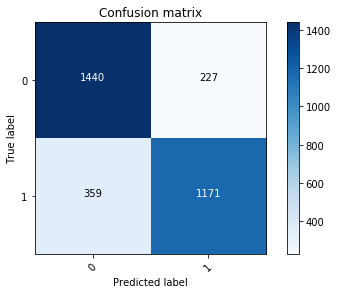

INFO:utils.mura_metrics:Accuracy: 0.8198498748957465
INFO:utils.mura_metrics:Kappa: 0.6316635330058397
INFO:utils.mura_metrics:Precision: 0.8411016949152542
INFO:utils.mura_metrics:Recall: 0.7379182156133829


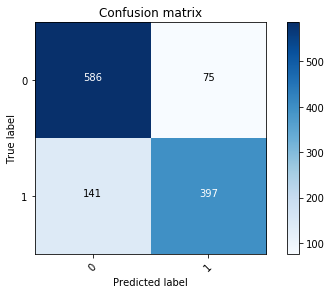

INFO:__main__:Saving Model to trained_models/5_1_shared_net_10.h5...
INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 11-20


INFO:utils.mura_metrics:Accuracy: 0.8157647794807632
INFO:utils.mura_metrics:Kappa: 0.6290083584941905
INFO:utils.mura_metrics:Precision: 0.8498141263940521
INFO:utils.mura_metrics:Recall: 0.7470588235294118


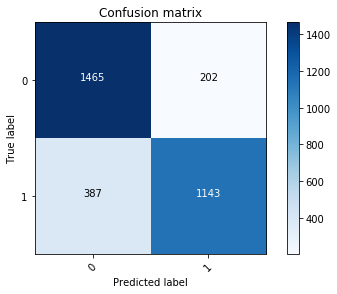

INFO:utils.mura_metrics:Accuracy: 0.823185988323603
INFO:utils.mura_metrics:Kappa: 0.6365773174651287
INFO:utils.mura_metrics:Precision: 0.8687782805429864
INFO:utils.mura_metrics:Recall: 0.7137546468401487


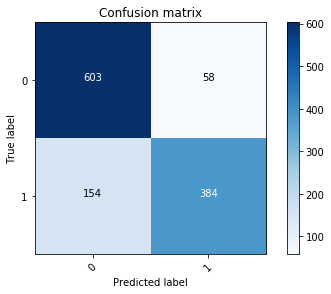

INFO:__main__:Saving Model to trained_models/5_1_shared_net_20.h5...
INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 21-30


INFO:utils.mura_metrics:Accuracy: 0.8204566781357523
INFO:utils.mura_metrics:Kappa: 0.6383489864742359
INFO:utils.mura_metrics:Precision: 0.8583208395802099
INFO:utils.mura_metrics:Recall: 0.7483660130718954


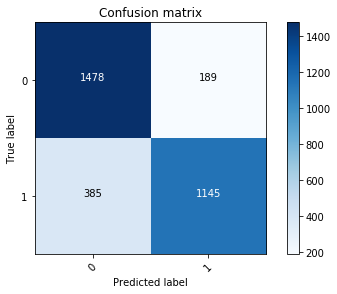

INFO:utils.mura_metrics:Accuracy: 0.8248540450375312
INFO:utils.mura_metrics:Kappa: 0.640005833338099
INFO:utils.mura_metrics:Precision: 0.8710407239819005
INFO:utils.mura_metrics:Recall: 0.7156133828996283


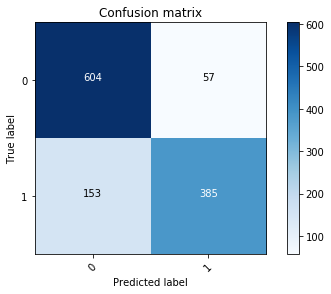

INFO:__main__:Saving Model to trained_models/5_1_shared_net_30.h5...
INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 31-40


INFO:utils.mura_metrics:Accuracy: 0.8207694713794182
INFO:utils.mura_metrics:Kappa: 0.6387742292840226
INFO:utils.mura_metrics:Precision: 0.8644325971058644
INFO:utils.mura_metrics:Recall: 0.7418300653594772


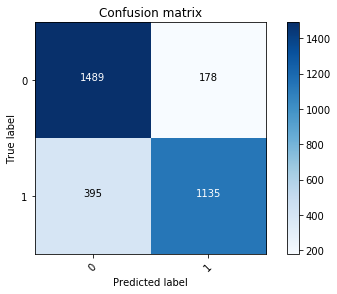

INFO:utils.mura_metrics:Accuracy: 0.8248540450375312
INFO:utils.mura_metrics:Kappa: 0.6393716395635621
INFO:utils.mura_metrics:Precision: 0.8796296296296297
INFO:utils.mura_metrics:Recall: 0.7063197026022305


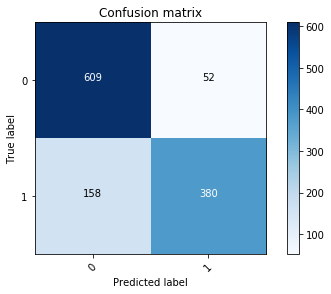

INFO:__main__:Saving Model to trained_models/5_1_shared_net_40.h5...
INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 41-50


INFO:utils.mura_metrics:Accuracy: 0.8107600875821083
INFO:utils.mura_metrics:Kappa: 0.619033315639314
INFO:utils.mura_metrics:Precision: 0.8413284132841329
INFO:utils.mura_metrics:Recall: 0.7450980392156863


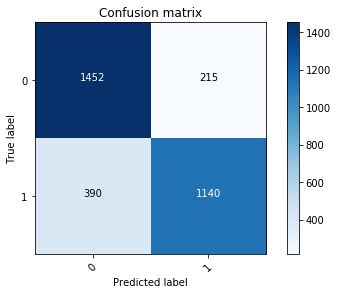

INFO:utils.mura_metrics:Accuracy: 0.8198498748957465
INFO:utils.mura_metrics:Kappa: 0.6297202857191877
INFO:utils.mura_metrics:Precision: 0.8642533936651584
INFO:utils.mura_metrics:Recall: 0.7100371747211895


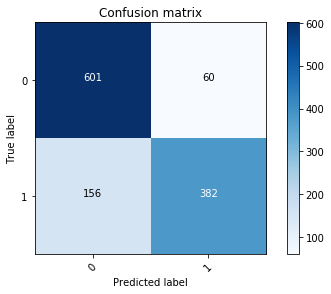

INFO:__main__:Saving Model to trained_models/5_1_shared_net_50.h5...
INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 51-60


INFO:utils.mura_metrics:Accuracy: 0.8148263997497655
INFO:utils.mura_metrics:Kappa: 0.6271489490130783
INFO:utils.mura_metrics:Precision: 0.8479228486646885
INFO:utils.mura_metrics:Recall: 0.7470588235294118


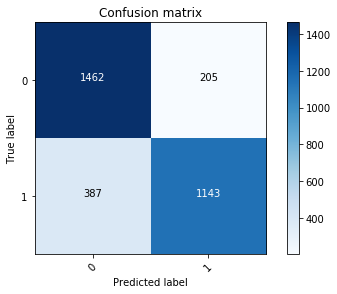

INFO:utils.mura_metrics:Accuracy: 0.823185988323603
INFO:utils.mura_metrics:Kappa: 0.6365773174651287
INFO:utils.mura_metrics:Precision: 0.8687782805429864
INFO:utils.mura_metrics:Recall: 0.7137546468401487


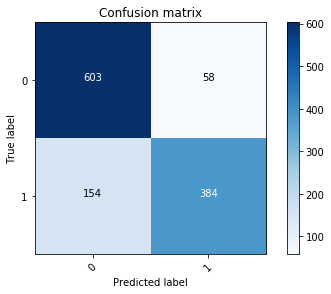

INFO:__main__:Saving Model to trained_models/5_1_shared_net_60.h5...
INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 61-70


INFO:utils.mura_metrics:Accuracy: 0.812011260556772
INFO:utils.mura_metrics:Kappa: 0.6216541972249215
INFO:utils.mura_metrics:Precision: 0.8402930402930403
INFO:utils.mura_metrics:Recall: 0.7496732026143791


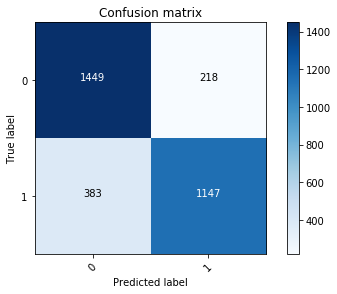

INFO:utils.mura_metrics:Accuracy: 0.8273561301084237
INFO:utils.mura_metrics:Kappa: 0.6454603502927677
INFO:utils.mura_metrics:Precision: 0.8702460850111857
INFO:utils.mura_metrics:Recall: 0.7230483271375465


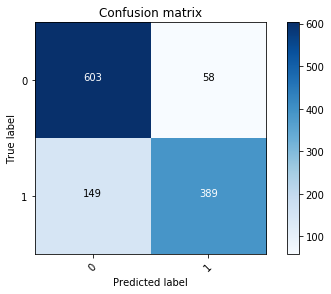

INFO:__main__:Saving Model to trained_models/5_1_shared_net_70.h5...
INFO:__main__:Saving evaluation metrics history...
INFO:__main__:executing epochs 71-80


In [ ]:
while (train_round+1) * epochs_per_eval + starting_epoch <= total_epochs:
    log.info(f'executing epochs {train_round * epochs_per_eval + 1 + starting_epoch}-{(train_round+1) * epochs_per_eval + starting_epoch}')
        
    curr_round = train_round * epochs_per_eval + 1 + starting_epoch
    if curr_round >= 10:
        if np.min(train_history['loss'][-10:-5]) <= np.min(train_history['loss'][-5:]): # if no improvements in 10 epochs
            base_lr = 0.5 * base_lr
            max_lr = 0.8 * max_lr
            opt = optimizers.Adam(lr=base_lr, amsgrad=True)
            clr_history['lr'].extend(clr.history['lr'])
            clr_history['loss'].extend(clr.history['loss'])
            clr_history['binary_accuracy'].extend(clr.history['binary_accuracy'])
            clr = utils.clr.CyclicLR(mode='triangular2', base_lr=base_lr, max_lr=max_lr)
    
    model.compile(
        loss=weighted_binary_crossentropy(p1),
        optimizer=opt,
        metrics=[metrics.binary_accuracy])
    
    model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size, shuffle=True),
                           steps_per_epoch = int(np.round(len(x_train) / batch_size)), 
                           epochs=epochs_per_eval, verbose=0,
                           callbacks=[clr, progress])
    
    train_history['loss'].extend(model.history.history['loss'])
    train_history['binary_accuracy'].extend(model.history.history['binary_accuracy'])
    
    y_valid_hat = model.predict(x_test)
    true_label = np.round(y_test)
    pred_label = np.round(y_valid_hat)
    evaluate = utils.MURAMetrics(true_label, pred_label)
    
    per_image_metrics = evaluate.report_by_image()
    for key in per_image_metrics:
        val_per_image_history[key].append(per_image_metrics[key])
       
    per_study_metrics = evaluate.report_by_study()
    for key in per_image_metrics:
        val_per_study_history[key].append(per_study_metrics[key])
    
    cur_epoch = (train_round + 1) * epochs_per_eval
    if cur_epoch % epochs_per_save == 0:
        log.info(f'Saving Model to trained_models/{model_name}_{cur_epoch + starting_epoch}.h5...')
        model.layers[-2].save(f'./trained_models/{model_name}_{cur_epoch + starting_epoch}.h5')
    weighted_binary_crossentropy(p1)
    log.info('Saving evaluation metrics history...')
    with open(f'./trained_models/{model_name}_clr_history.pkl', 'wb') as pkl_file:
        pickle.dump(clr_history, pkl_file)
    with open(f'./trained_models/{model_name}_train_history.pkl', 'wb') as pkl_file:
        pickle.dump(train_history, pkl_file)
    with open(f'./trained_models/{model_name}_val_per_image_history.pkl', 'wb') as pkl_file:
        pickle.dump(val_per_image_history, pkl_file)
    with open(f'./trained_models/{model_name}_val_per_study_history.pkl', 'wb') as pkl_file:
        pickle.dump(val_per_study_history, pkl_file)
    
    train_round += 1

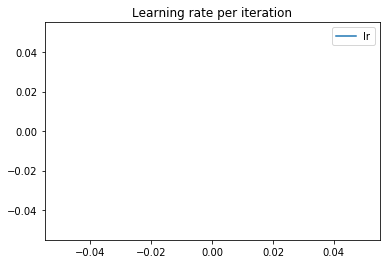

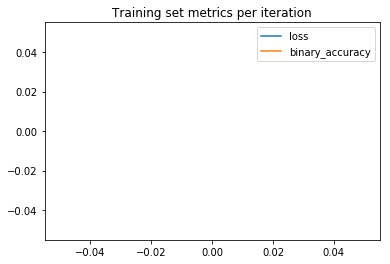

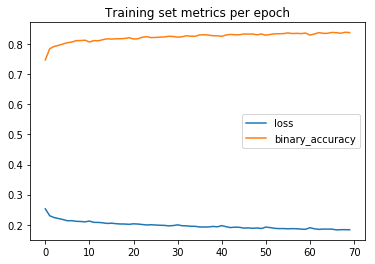

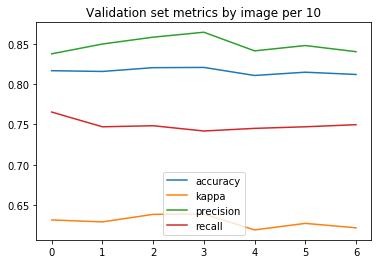

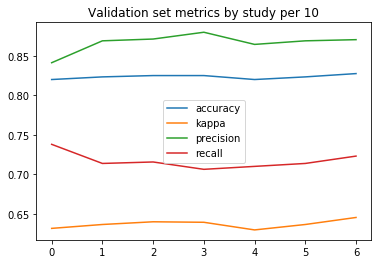

time: 749 ms


In [17]:
plt.plot(clr_history['lr'])
plt.title('Learning rate per iteration')
plt.legend(['lr'])
plt.show()

for metric in ['loss', 'binary_accuracy']:
    plt.plot(clr_history[metric])
plt.title('Training set metrics per iteration')
plt.legend(['loss', 'binary_accuracy'])
plt.show()

for metric in train_history.keys():
    plt.plot(train_history[metric])
plt.title('Training set metrics per epoch')
plt.legend(train_history.keys())
plt.show() 

for metric in val_per_image_history.keys():
    plt.plot(val_per_image_history[metric])
plt.title(f'Validation set metrics by image per {epochs_per_eval}')
plt.legend(val_per_image_history.keys())
plt.show() 

for metric in val_per_study_history.keys():
    plt.plot(val_per_study_history[metric])
plt.title(f'Validation set metrics by study per {epochs_per_eval}')
plt.legend(val_per_study_history.keys())
plt.show() 